In [1]:
import os, pickle
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC, LinearSVC
from aix360.algorithms.protodash import ProtodashExplainer
import matplotlib.pyplot as plt
from pdash import pdash_e, proto_g
# from protoclass.protoclass import ProtoclassExplainer, protoclass

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")
import utils

In [2]:
if True:
    SMALL_SIZE = 10
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def vis_data(x_train, y_train, x_valid, y_valid, title, save=False):
    classes = np.unique(y_train)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i, data in enumerate([(x_train, y_train),(x_valid, y_valid)]):
        x, y = data
        for c in classes:
            c_idx = np.where(y==c)[0]
            ax[i].scatter(x[c_idx][:,0], x[c_idx][:,1])

        ax[i].legend(['non-cancer','cancer'])
        ax[i].set_title("{}".format("train" if i == 0 else "valid"))
    
    utils.normalize_xylim(ax)
    fig.suptitle(title)
    if save:
        plt.savefig(f"{title}.png", dpi=300)

def vis_proto(x_train, y_train,train_proto_idx, title, save=False, order=False, eps=0, x_valid=None, y_valid=None,valid_proto_idx=None):
    classes = np.unique(y_train)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # for i, data in enumerate([(x_train, y_train),(x_valid, y_valid)]):
    for i, data in enumerate([(x_train, y_train)]):
        x, y = data
        for c in classes:
            c_idx = np.where(y==c)[0]
            ax[i].scatter(x[c_idx][:,0], x[c_idx][:,1])
        ax[i].legend(['non-cancer','cancer'])
        ax[i].set_title(title)
        # ax[i].set_title("{}.{}.{}".format(model, name, "train" if i == 0 else "valid"))

    for j, c in enumerate(classes):
        train_proto = x_train[[int(i) for i in train_proto_idx if y_train[i] == c]]
        ax[0].scatter(train_proto[:,0], train_proto[:,1], s=300, c=f"C{str(j)}", marker='^', linewidths=1, edgecolors='k') 
        # valid_proto = x_valid[[int(i) for i in valid_proto_idx if y_valid[i] == c]]
        # ax[1].scatter(valid_proto[:,0], valid_proto[:,1], s=300, c=f"C{str(j)}",marker='^', linewidths=1, edgecolors='k') 

    for o, i in enumerate(train_proto_idx):
        proto = x_train[i]
        c = plt.Circle(proto, radius=eps, fill=False,lw=0.75)
        
        if order:
            ax[0].text(proto[0],proto[1],str(o), size="xx-large", weight="bold", c="0")
        ax[0].add_patch(c)

    if save:
        plt.savefig(f"{title}.png", dpi=300)

def vis_triplets(x_train, y_train, triplet_dict, title, save=False):
    classes = np.unique(y_train)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i, data in enumerate([(x_train, y_train)]):
        x, y = data
        for c in classes:
            c_idx = np.where(y==c)[0]
            ax[i].scatter(x[c_idx][:,0], x[c_idx][:,1])
        
        ax[i].legend(['non-cancer','cancer'])
        ax[i].set_title("{}".format("train" if i == 0 else "valid"))
    
    for i, triplet in enumerate(triplet_dict):
        anchor, pos, neg = triplet
        anchor = x_train[anchor]
        pos = x_train[pos]
        neg = x_train[neg]
        ax[0].scatter(anchor[0], anchor[1], s=300, c='0.5', marker='^', linewidths=1, edgecolors='k') 
        ax[0].scatter(pos[0], pos[1], s=300, c='0', marker='^', linewidths=1, edgecolors='k') 
        ax[0].scatter(neg[0], neg[1], s=300, c='1', marker='^', linewidths=1, edgecolors='k') 
        ax[0].text(anchor[0], anchor[1], str(i), c='0', size="xx-large", weight="bold") 
        ax[0].text(pos[0], pos[1], str(i), c='0', size="xx-large", weight="bold") 
        ax[0].text(neg[0], neg[1], str(i), c='0', size="xx-large", weight="bold") 

    # utils.normalize_xylim(ax)
    fig.suptitle(title)
    if save:
        plt.savefig(f"{title}.png", dpi=300)

def vis_proto_2(x_train, y_train, proto_idx1, proto_idx2, title, save=False, order=False, eps=0):
    classes = np.unique(y_train)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i, data in enumerate([(x_train, y_train)]):
        x, y = data
        for c in classes:
            c_idx = np.where(y==c)[0]
            ax[i].scatter(x[c_idx][:,0], x[c_idx][:,1])
        ax[i].legend(['non-cancer','cancer'])
        ax[i].set_title(title)

        protos1 = x_train[proto_idx1]
        protos2 = x_train[proto_idx2]
        ax[i].scatter(protos1[:,0], protos1[:,1], s=300, c = 'g', marker='^', linewidths=1, edgecolors='k') 
        ax[i].scatter(protos2[:,0], protos2[:,1], s=300, c = 'r', marker='^', linewidths=1, edgecolors='k') 
    if save:
        plt.savefig(f"{title}.png", dpi=300)
    
def vis_knn(k_range, m_range, scores, legend, title, save=False):
    lw = 3
    fig, ax = plt.subplots(1, len(k_range), figsize=(24,6), sharey=True)
    for k in range(len(k_range)):
        for score in scores:
            ax[k].plot(m_range, score[k], lw=lw)

        ax[k].legend(legend, loc='lower right')
        ax[k].set_title('K={}'.format(k_range[k]))
    fig.suptitle(title)

    if save:
        plt.savefig(f"{title}.png", dpi=300)

## generate triplets from LPIPS distance matrices
triplets.shape := [k, 3]

triplets[i] = [anchor, positive, negative]

In [3]:
distance_matrix = pickle.load(open("lpips.prostatex.train+valid.pkl", "rb"))
distance_matrix.shape

(319, 319)

In [4]:
triplets_fname = "data/triplets.px.train+valid.pkl"
tste_fname = "data/tste.px.train+valid.pkl"

In [5]:
# embeds = utils.get_tste(distance_matrix, triplets_fname, tste_fname, max_iter=100)

(256, 2)

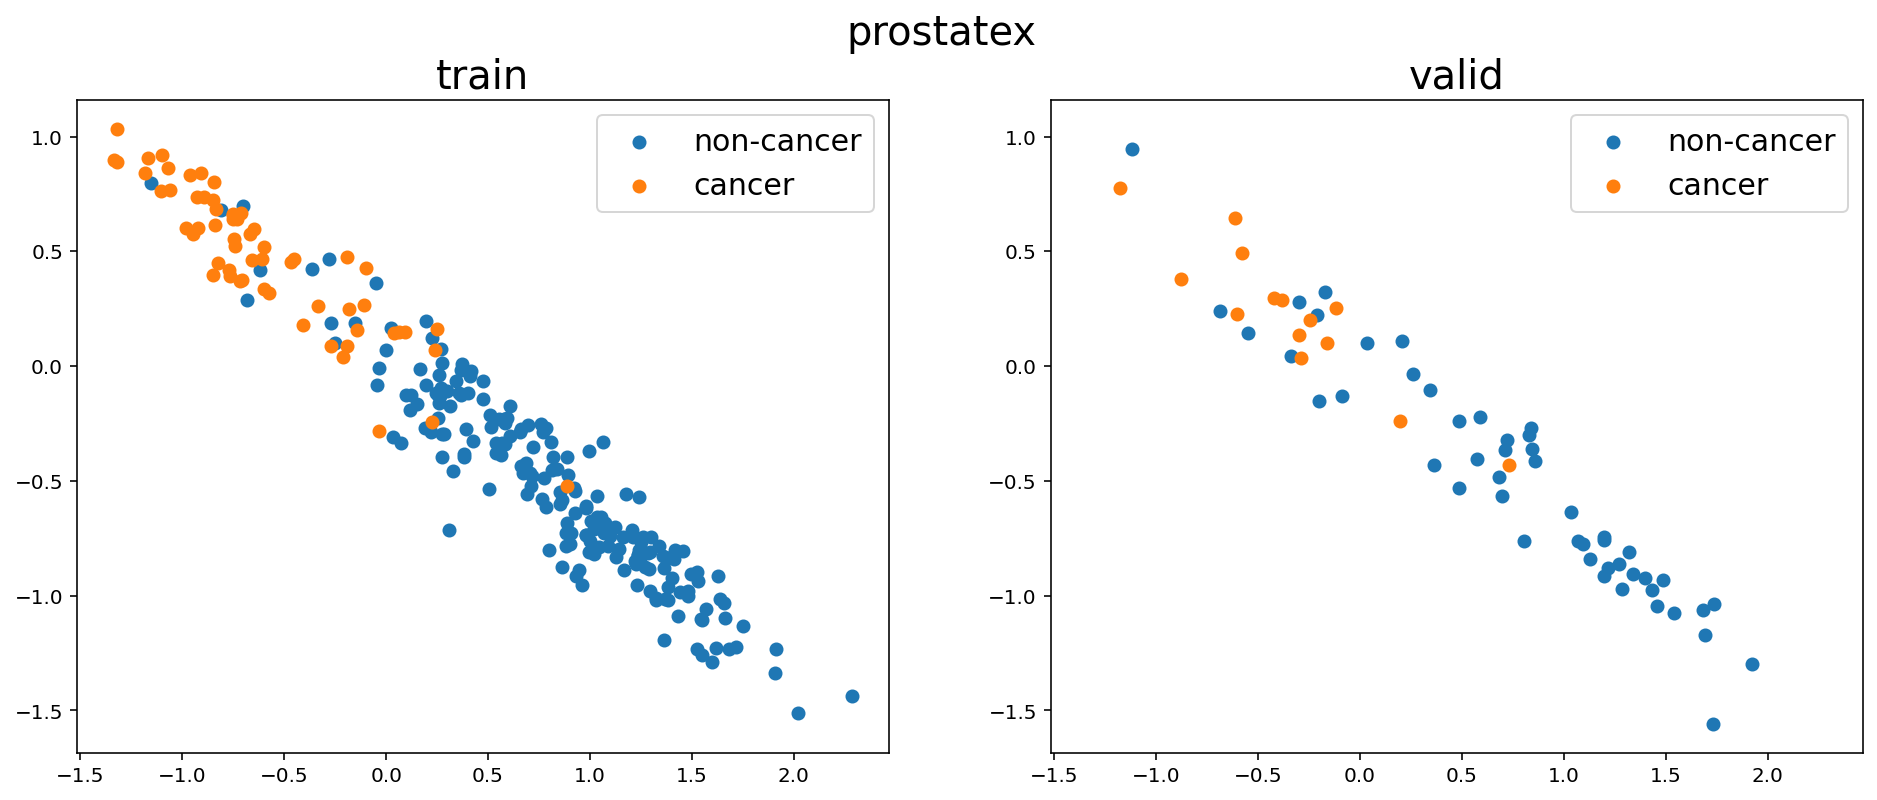

In [6]:
model, name = 'dwac', 'emb10.merged2'
title = "prostatex"

train_path = '{}_train_{}.pkl'.format(model, name)
f_train_dwac, y_train_dwac, x_train_dwac = pickle.load(open(train_path, "rb"))
valid_path = '{}_valid_{}.pkl'.format(model, name)
f_valid_dwac, y_valid_dwac, x_valid_dwac = pickle.load(open(valid_path, "rb"))
vis_data(x_train_dwac, y_train_dwac, x_valid_dwac, y_valid_dwac, title, save=False)
x_train_dwac.shape

(319, 2)

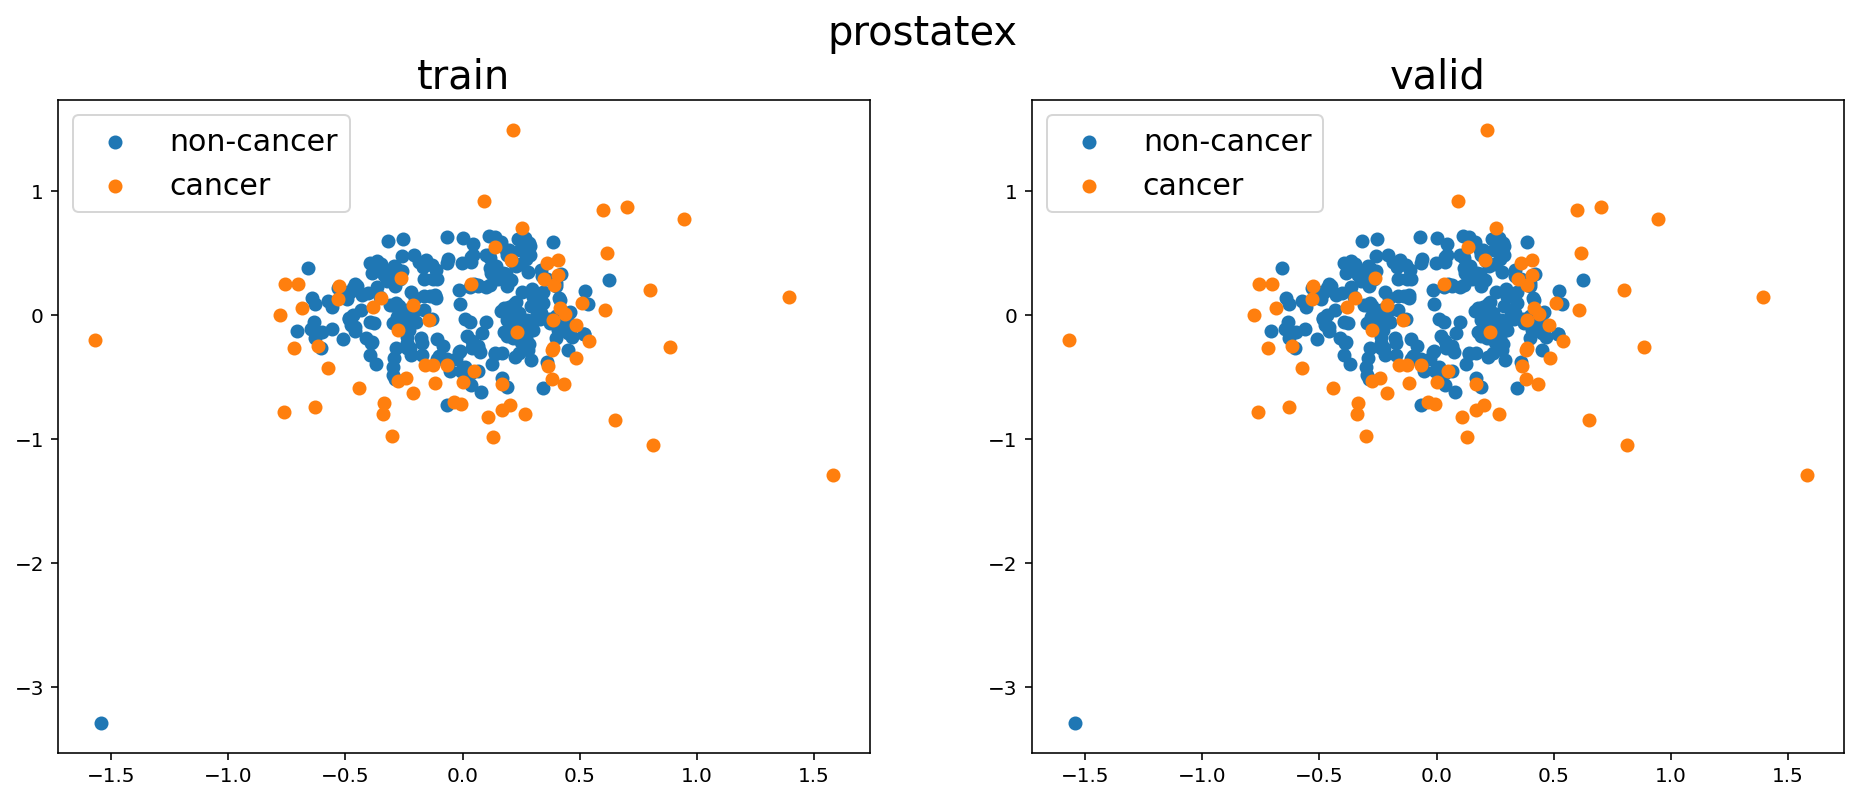

In [7]:
title = "prostatex"

tste_path = 'tste_all_px.pkl'
f_tste, y_tste, x_tste = pickle.load(open(tste_path, "rb"))
vis_data(x_tste, y_tste, x_tste, y_tste, title, save=False)
x_tste.shape

(256, 2)

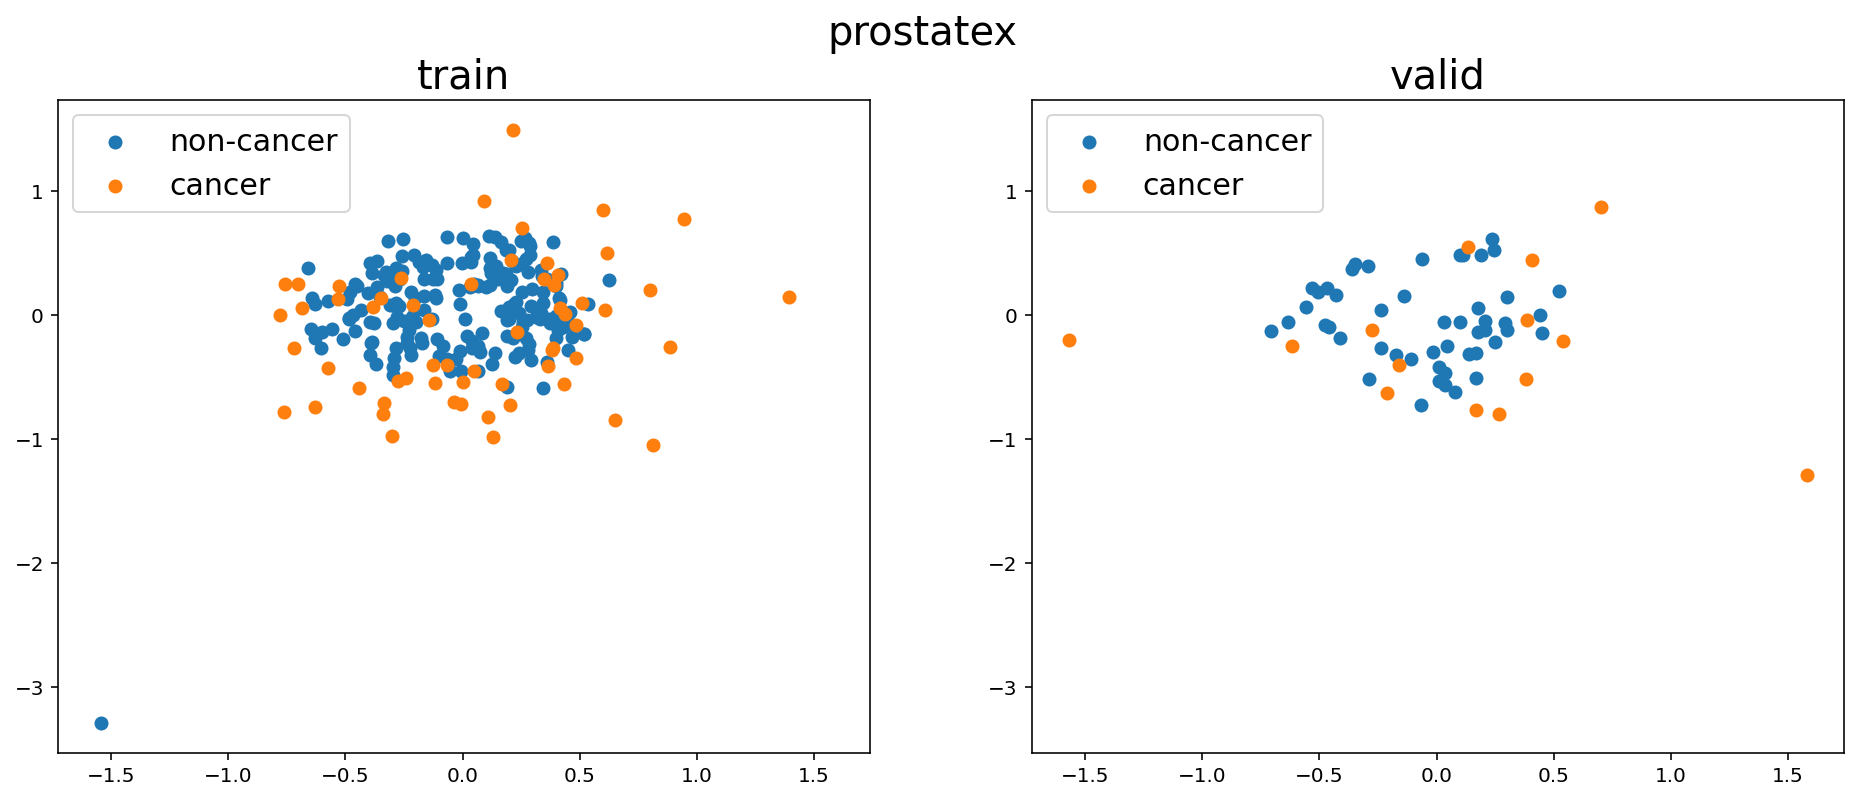

In [8]:
title = "prostatex"
model, name = "tste", "px"

train_path = '{}_train_{}.pkl'.format(model, name)
f_train_tste, y_train_tste, x_train_tste = pickle.load(open(train_path, "rb"))
valid_path = '{}_valid_{}.pkl'.format(model, name)
f_valid_tste, y_valid_tste, x_valid_tste = pickle.load(open(valid_path, "rb"))
vis_data(x_train_tste, y_train_tste, x_valid_tste, y_valid_tste, title, save=False)
x_train_tste.shape

## knn/svm on tste embeds

In [22]:
L = 0.5
Kernel = 'Gaussian'
Gamma = 0.5

k_range = [1, 3]
m_range = list(range(3, 11))

In [9]:
dataset = 'prostatex'
model = 'dwac'
name = 'emb10.merged2'
train_path = '{}_train_{}.pkl'.format(model, name)
valid_path = '{}_valid_{}.pkl'.format(model, name)
f_train, y_train, X_train = pickle.load(open(train_path, "rb"))
f_valid, y_valid, X_valid = pickle.load(open(valid_path, "rb"))
data = X_train, y_train, X_valid, y_valid
# pos_id = np.where(y_train > 0)[0]
# neg_id = np.where(y_train == 0)[0]
# X_pos = X_train[y_train > 0]
# X_neg = X_train[y_train == 0]

In [14]:
f_scores_knn, f_score_svm = utils.get_full_score(data, k_range)
r_means_knn, r_confs_knn, r_means_svm, r_confs_svm = utils.get_random_score(data, k_range, m_range)
p_scores_knn, p_scores_svm = utils.get_protodash_score(data, k_range, m_range)

In [187]:
# c_idss = {}
# X_train, y_train, X_valid, y_valid = data
# _, c_idss = protoclass(X_train, X_train, y_train, m_range)
# pickle.dump(c_idss, open("c_index.{}.{}.{}.pkl".format(dataset, model, name), "wb"))
c_idss = pickle.load(open("c_index.{}.{}.{}.pkl".format(dataset, model, name), "rb"))
print([len(ids) for ids in c_idss.values()])
c_scores_knn, c_scores_svm = [], []
for k in k_range:
    for m in m_range:
        c_scores_knn.append(utils.get_knn_score(k, data, c_idss[m]))
        c_scores_svm.append(utils.get_svm_score(k, data, c_idss[m]))
c_scores_knn = np.array(c_scores_knn).reshape(len(k_range), len(m_range))
c_scores_svm = np.array(c_scores_svm).reshape(len(k_range), len(m_range))

[3, 4, 5, 6, 7, 8, 9, 10]


Text(0.5, 0.98, 'prostatex, dwac.emb10.merged2, AUC, KNN weights uniform')

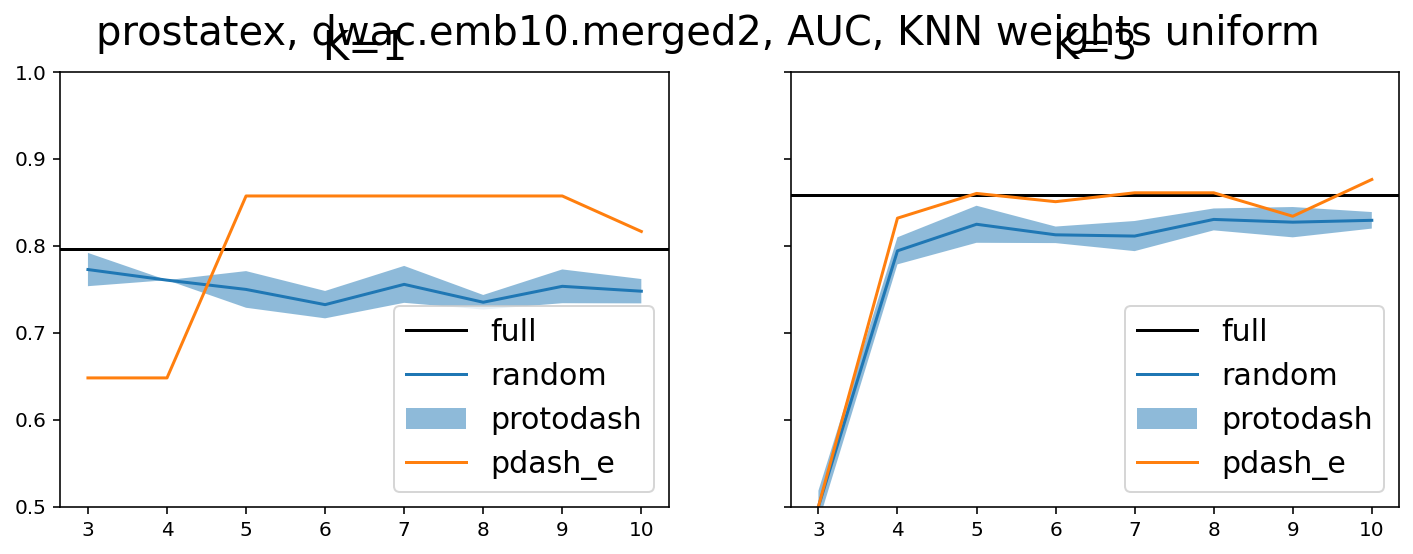

In [15]:
fig, ax = plt.subplots(1, len(k_range), figsize=(12, 4), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(f_scores_knn[k], c='black')
    ax[k].plot(m_range, r_means_knn[k])
    ax[k].fill_between(m_range, r_means_knn[k] + r_confs_knn[k] / 2, r_means_knn[k] - r_confs_knn[k] / 2, alpha=0.5)
    ax[k].plot(m_range, p_scores_knn[k])
    ax[k].set_ylim(0.5, 1)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['full', 'random', 'protodash', 'pdash_e', 'proto_g', 'protoclass', 'lpips'])
fig.suptitle('{}, {}.{}, AUC, KNN weights '.format(dataset, model, name) + "uniform")

In [16]:
model, name = "tste", "px"
train_path = '{}_train_{}.pkl'.format(model, name)
valid_path = '{}_valid_{}.pkl'.format(model, name)
f_train_tste, y_train_tste, x_train_tste = pickle.load(open(train_path, "rb"))
f_valid_tste, y_valid_tste, x_valid_tste = pickle.load(open(valid_path, "rb"))

data = x_train_tste, y_train_tste, x_valid_tste, y_valid_tste
# pos_id = np.where(y_train_tste > 0)[0]
# neg_id = np.where(y_train_tste == 0)[0]
# X_pos = x_train_tste[y_train_tste > 0]
# X_neg = x_train_tste[y_train_tste == 0]

In [17]:
f_scores_knn, f_score_svm = utils.get_full_score(data, k_range)
r_means_knn, r_confs_knn, r_means_svm, r_confs_svm = utils.get_random_score(data, k_range, m_range)
p_scores_knn, p_scores_svm = utils.get_protodash_score(data, k_range, m_range)

Text(0.5, 0.98, 'prostatex, tste.px, AUC, KNN weights uniform')

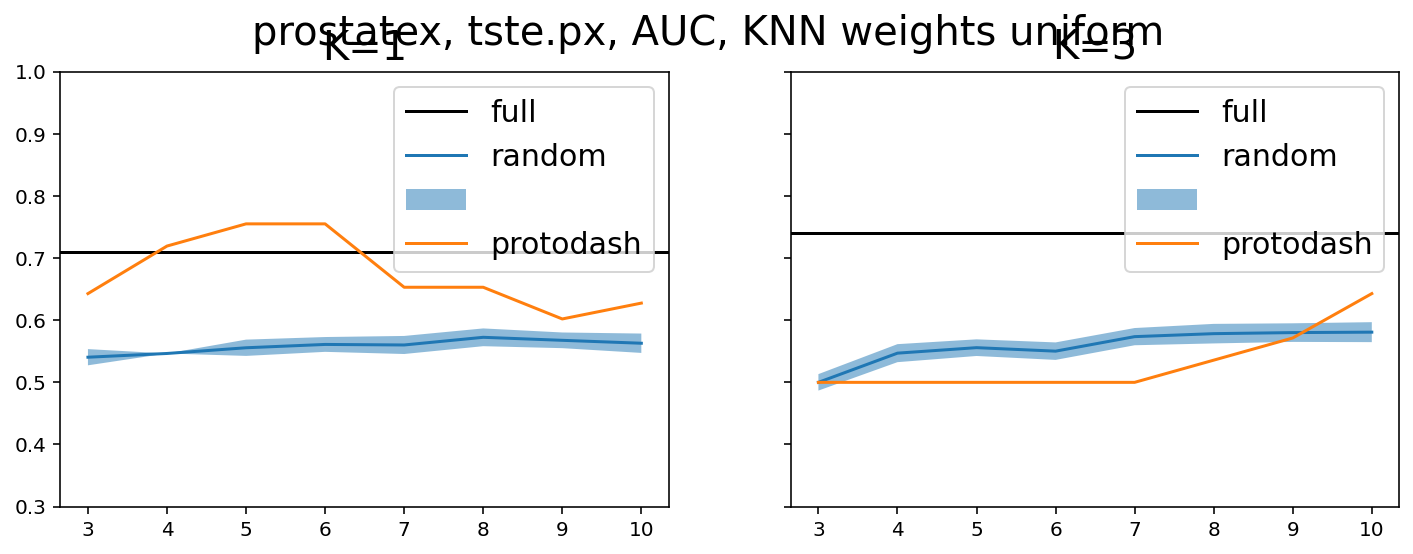

In [21]:
fig, ax = plt.subplots(1, len(k_range), figsize=(12, 4), sharey=True)
for k in range(len(k_range)):
    ax[k].axhline(f_scores_knn[k], c='black')
    ax[k].plot(m_range, r_means_knn[k])
    ax[k].fill_between(m_range, r_means_knn[k] + r_confs_knn[k] / 2, r_means_knn[k] - r_confs_knn[k] / 2, alpha=0.5)
    ax[k].plot(m_range, p_scores_knn[k])
    ax[k].set_ylim(0.3, 1)
    ax[k].set_xticks(m_range)
    ax[k].set_title('K={}'.format(k_range[k]))
    ax[k].legend(['full', 'random', "", 'protodash', 'pdash_e', 'proto_g', 'protoclass', 'lpips'])
fig.suptitle('{}, {}.{}, AUC, KNN weights '.format(dataset, model, name) + "uniform")